In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pywt
# print(cv2.__version__)

from skimage.metrics import structural_similarity as ssim

import lpips 
import torch
from scipy.signal import wiener, convolve2d
from skimage import color, data, restoration

try:
    from skimage.restoration import denoise_tv_chambolle
except ImportError:
    # skimage < 0.12
    from skimage.filters import denoise_tv_chambolle

import scipy.misc

from image_filters import anisodiff, notch_filter

from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift

from bm3d import bm3d_rgb, BM3DProfile
import bm3d

import glob
import pandas as pd

In [3]:
def rgb2gray(rgb):
  "used for ssim"
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def get_metrics_diff(ground_truth, reconstructed, filtered, name='', output_recons=True,use_lpips=True):
    ## PSNR
    # print(name)
    recons_PSNR = cv2.PSNR(ground_truth, reconstructed)
    filter_PSNR = cv2.PSNR(ground_truth, filtered)
    # if output_recons:
    #   print('recons PSNR:', recons_PSNR)

    diff = (filter_PSNR - recons_PSNR) / recons_PSNR
    psnr_diff = round(diff * 100, 3)
    # print('PSNR:', filter_PSNR,', % change: ', diff)

    ## SSIM
    # converting to grayscale
    rgb_predicted1 = rgb2gray(reconstructed)
    target_img1 = rgb2gray(ground_truth)
    recons_SSIM = ssim(target_img1, rgb_predicted1,
                       data_range=rgb_predicted1.max() - rgb_predicted1.min())
    # if output_recons:
    #   print('recons SSIM:', recons_SSIM)
    
    rgb_predicted1 = rgb2gray(filtered)
    filter_SSIM = ssim(target_img1, rgb_predicted1,
                       data_range=rgb_predicted1.max() - rgb_predicted1.min())
    diff = (filter_SSIM - recons_SSIM) / recons_SSIM
    ssim_diff = round(diff * 100, 3)
    # print('SSIM: ', filter_SSIM, ', % change: ', diff)
    # print()

    ## LPIPS
    if use_lpips:
      loss_fn = lpips.LPIPS(net='alex') # best forward scores
      loss_fn.cuda()

      img0 = lpips.im2tensor(ground_truth)
      img1 = lpips.im2tensor(reconstructed)
      img2 = lpips.im2tensor(filtered)

      img0 = img0.cuda()
      img1 = img1.cuda()
      img2 = img2.cuda()

      recons_LPIPS = loss_fn.forward(img0, img1)
      recons_LPIPS = round(float(recons_LPIPS), 3)
      filter_LPIPS = loss_fn.forward(img0, img2)
      filter_LPIPS = round(float(filter_LPIPS), 3)

      # if output_recons:
        # print('recons LPIPS:', recons_LPIPS)

      diff = (recons_LPIPS - filter_LPIPS)/recons_LPIPS
      lpips_diff = round(diff * 100, 3)
      # print('LPIPS:', filter_LPIPS, ', % change: ', diff)
      return psnr_diff, ssim_diff, lpips_diff
    else:
      return psnr_diff, ssim_diff

In [4]:
def plot_images(reconstructed, filtered, gray=False):
    fig,ax = plt.subplots(1,2)
    
    if gray==True:
        ax[0].imshow(reconstructed, cmap=plt.get_cmap('gray'))
    else:
        ax[0].imshow(reconstructed)
    ax[0].set_title("Reconstructed")

    if gray==True:
        ax[1].imshow(filtered, cmap=plt.get_cmap('gray'))
    else:
        ax[1].imshow(filtered)
    ax[1].set_title("Filtered")

In [5]:
# Load the ground truth and reconstructed images
gt_folder = '../running_outputs/lego_orig_all/*.png'
reconst_folder = '../running_outputs/KiloNeRF_16epochs_400/*.png'
gt_images = [file for file in glob.glob(gt_folder)]
reconst_images = [file for file in glob.glob(reconst_folder)]

def read_images(gt_image, reconst_image):
    ground_truth = cv2.imread(gt_image)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

    reconstructed = cv2.imread(reconst_image)
    reconstructed = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB)

    return ground_truth, reconstructed

In [6]:
img_pairs = []
for reconst_img in reconst_images:
    reconst_name = '/'+reconst_img.split("/")[-1]
    gt_name = [fn for fn in gt_images if reconst_name in fn]
    if len(gt_name) == 0:
        pass
    else: 
        img_pairs.append([reconst_img, gt_name[0]])

### MID-DRAN Denoising

In [11]:
reconstructed_path = "/home/sayyor/Desktop/BDMA_Studies/MID-DRAN-main/testingImages/sampleImages/nerf_1.png"
original_path = "/home/sayyor/Desktop/BDMA_Studies/MID-DRAN-main/nerf_1.png"
denoised_path = "/home/sayyor/Desktop/BDMA_Studies/MID-DRAN-main/modelOutput/sampleImages/nerf_1_25.png"

reconstructed = cv2.imread(reconstructed_path)
reconstructed = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB)

original = cv2.imread(original_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

denoised = cv2.imread(denoised_path)
denoised = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

In [8]:
plot_images(reconstructed, denoised)

NameError: name 'denoised' is not defined

In [15]:
get_metrics_diff(original, reconstructed, denoised, '')


recons PSNR: 24.872632230291277
PSNR: 23.58050155720212 , % change:  -5.195
recons SSIM: 0.8815390508654835
SSIM:  0.8453917271151534 , % change:  -4.1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
recons LPIPS: 0.098
LPIPS: 0.12 , % change:  -22.449


# Gaussian Blur

In [9]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    gaussian_blur = cv2.GaussianBlur(reconstructed, (5, 5), 0)

    psnr_diff, ssim_diff, lpips_diff = get_metrics_diff(ground_truth, reconstructed, gaussian_blur, 'Gaussian Blur')
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

Gaussian Blur
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Gaussian Blur
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Gaussian Blur
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Gaussian Blur
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Gaussian Blur
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Gaussian Bl

In [14]:
metrics_diffs = {}
gaussian_diffs = {
    'psnr_mean': np.mean(psnr_diffs), 'psnr_std': np.std(psnr_diffs), 
    'ssim_mean': np.mean(ssim_diffs), 'ssim_std': np.std(ssim_diffs),
    'lpips_mean': np.mean(lpips_diffs), 'lpips_std': np.std(lpips_diffs)}

metrics_diffs['gaussian_blur'] = gaussian_diffs

In [20]:
df = pd.DataFrame(metrics_diffs)
df.to_csv('metrics_diffs.csv')

In [18]:
df = pd.read_csv('metrics_diffs.csv')

In [22]:
df = df.rename(columns={"Unnamed: 0": "metrics"})

# Median Filter

In [10]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    median_filtered = cv2.medianBlur(reconstructed, 5)

    psnr_diff, ssim_diff, lpips_diff = get_metrics_diff(ground_truth, reconstructed, median_filtered, 'Gaussian Blur')
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [

In [25]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['median_filter'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

# Bilateral Filter

In [28]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    bilateral_filter = cv2.bilateralFilter(reconstructed, 9, 75, 75)

    psnr_diff, ssim_diff, lpips_diff = get_metrics_diff(ground_truth, reconstructed, median_filtered, 'Gaussian Blur')
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [

In [30]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['bilateral_filter'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

# Non-local Means Denoising

In [32]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    non_local_means = cv2.fastNlMeansDenoisingColored(reconstructed,None, 10, 10, 7, 21)

    psnr_diff, ssim_diff, lpips_diff = get_metrics_diff(ground_truth, reconstructed, non_local_means, '')
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [

In [52]:
metrics_diffs

{'Unnamed: 0': {0: 'lpips_mean',
  1: 'lpips_std',
  2: 'psnr_mean',
  3: 'psnr_std',
  4: 'ssim_mean',
  5: 'ssim_std'},
 'gaussian_blur': {0: -221.424645,
  1: 71.22734497156956,
  2: -4.503115,
  3: 2.2150571125311878,
  4: -2.84147,
  5: 1.0296869908375068},
 'median_filter': {2: -5.852715,
  3: 2.911168537507748,
  4: -4.673414999999999,
  5: 1.957168861589362,
  0: -145.469325,
  1: 53.23022460819956},
 'bilateral_filter': {2: -60.22204000000001,
  3: 6.765156944846143,
  4: -31.136725,
  5: 5.275701971242785,
  0: -734.422685,
  1: 242.80210673716525},
 'non_local_means': {2: -3.30201,
  3: 1.625535979269607,
  4: -2.7569600000000003,
  5: 1.6682572398763926,
  0: -120.07709000000001,
  1: 51.74000224460664},
 'wavelete_transform': {2: -5.777282051282051,
  3: 2.3543494822454964,
  4: -2.7629230769230766,
  5: 0.7749797477789053,
  0: -89.7853076923077,
  1: 37.13334377007208},
 'wiener': {2: -3.0283399999999996,
  3: 1.719627024793458,
  4: 5.995335,
  5: 5.778937926018499,
  0

In [34]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['non_local_means'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

# Wavenet Transformation

In [36]:
def wavelet_denoising_color(image):
    # Function to pad an image to the next power of two
    def pad_to_power_of_two(img):
        rows, cols = img.shape[:2]
        nrows, ncols = 2**np.ceil(np.log2(rows)), 2**np.ceil(np.log2(cols))
        return cv2.copyMakeBorder(img, 0, int(nrows-rows), 0, int(ncols-cols), cv2.BORDER_REFLECT)

    # Function to crop the image back to original size
    def crop_to_original_size(img, original):
        rows, cols = original.shape[:2]
        return img[:rows, :cols]

    original_size = image.shape[:2]
    padded_image = pad_to_power_of_two(image)
    channels = cv2.split(padded_image)
    denoised_channels = []

    for channel in channels:
        coeffs = pywt.wavedec2(channel, 'db1', level=1)
        cA, (cH, cV, cD) = coeffs

        cH = pywt.threshold(cH, value=0.5 * np.max(cH), mode='soft')
        cV = pywt.threshold(cV, value=0.5 * np.max(cV), mode='soft')
        cD = pywt.threshold(cD, value=0.5 * np.max(cD), mode='soft')

        denoised_channel = pywt.waverec2((cA, (cH, cV, cD)), 'db1')
        denoised_channels.append(denoised_channel)

    denoised_image = cv2.merge(denoised_channels)
    denoised_image = crop_to_original_size(denoised_image, image)

    return denoised_image

In [40]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    wavelet_denoised = wavelet_denoising_color(reconstructed)
    wavelet_denoised = wavelet_denoised.astype(np.uint8)

    psnr_diff, ssim_diff, lpips_diff = get_metrics_diff(ground_truth, reconstructed, wavelet_denoised, '')
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/sayyor/.local/share/virtualenvs/BDRP-anF7eHmv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [

In [38]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['wavelete_transform'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

In [41]:
metrics_diffs

{'Unnamed: 0': {0: 'lpips_mean',
  1: 'lpips_std',
  2: 'psnr_mean',
  3: 'psnr_std',
  4: 'ssim_mean',
  5: 'ssim_std'},
 'gaussian_blur': {0: -221.424645,
  1: 71.22734497156956,
  2: -4.503115,
  3: 2.2150571125311878,
  4: -2.84147,
  5: 1.0296869908375068},
 'median_filter': {2: -5.852715,
  3: 2.911168537507748,
  4: -4.673414999999999,
  5: 1.957168861589362,
  0: -145.469325,
  1: 53.23022460819956},
 'bilateral_filter': {2: -60.22204000000001,
  3: 6.765156944846143,
  4: -31.136725,
  5: 5.275701971242785,
  0: -734.422685,
  1: 242.80210673716525},
 'non_local_means': {2: -3.30201,
  3: 1.625535979269607,
  4: -2.7569600000000003,
  5: 1.6682572398763926,
  0: -120.07709000000001,
  1: 51.74000224460664},
 'wavelete_transform': {2: -5.777282051282051,
  3: 2.3543494822454964,
  4: -2.7629230769230766,
  5: 0.7749797477789053,
  0: -89.7853076923077,
  1: 37.13334377007208}}

# Wiener

In [48]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    reconstructed_gray = rgb2gray(reconstructed)
    wiener_filter = wiener(reconstructed_gray, (5,5))
    ground_truth_gray = rgb2gray(ground_truth)

    psnr_diff, ssim_diff = get_metrics_diff(ground_truth_gray, reconstructed_gray, wiener_filter, '', use_lpips=False)
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

In [49]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['wiener'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

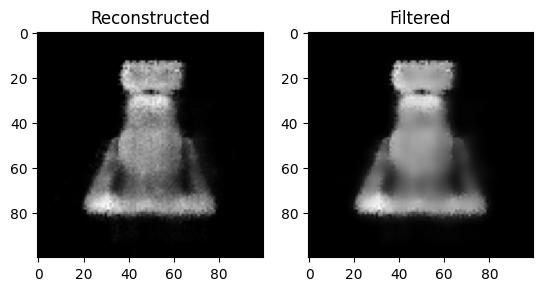

In [130]:
plot_images(reconstructed_gray, wiener_filter, gray=True)

# Anisotropic Diffusion

In [54]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    reconstructed_gray = rgb2gray(reconstructed)
    anisodiff_filtered = anisodiff(reconstructed_gray)
    anisodiff_filtered = np.float64(anisodiff_filtered)
    ground_truth_gray = rgb2gray(ground_truth)

    psnr_diff, ssim_diff = get_metrics_diff(ground_truth_gray, reconstructed_gray, anisodiff_filtered, '', use_lpips=False)
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

In [56]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['anisotropic_diffusion'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

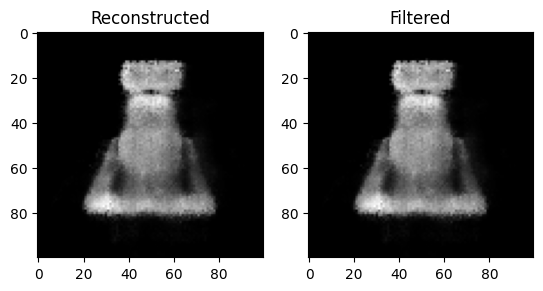

In [133]:
plot_images(reconstructed_gray,anisodiff_filtered,gray=True)

# Total Variation Denoising

In [57]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    reconstructed_gray = rgb2gray(reconstructed)
    tv_denoised = denoise_tv_chambolle(reconstructed_gray, weight=10)
    ground_truth_gray = rgb2gray(ground_truth)

    psnr_diff, ssim_diff = get_metrics_diff(ground_truth_gray, reconstructed_gray, tv_denoised, '', use_lpips=False)
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

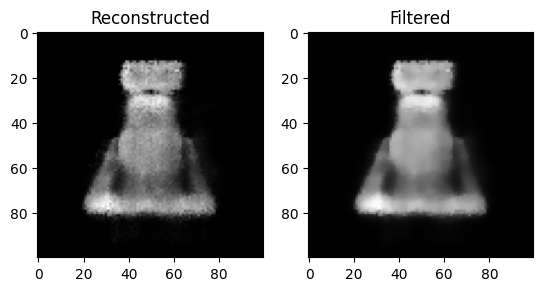

In [177]:
plot_images(reconstructed_gray,tv_denoised,gray=True)

In [58]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['tv_denoise'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

# Notch Filter

In [60]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    reconstructed_gray = rgb2gray(reconstructed)
    notch_filtered = notch_filter(reconstructed_gray)
    ground_truth_gray = rgb2gray(ground_truth)

    psnr_diff, ssim_diff = get_metrics_diff(ground_truth_gray, reconstructed_gray, notch_filtered, '', use_lpips=False)
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

In [64]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['notch_filtered'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

# Bandpass Filter

In [65]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
lpips_diffs = []

while img_id != len(img_pairs):
    reconstructed, ground_truth = img_pairs[img_id]
    ground_truth, reconstructed = read_images(ground_truth, reconstructed)
    
    reconstructed_gray = rgb2gray(reconstructed)
    bandpassed = difference_of_gaussians(reconstructed_gray, 1, 50)
    ground_truth_gray = rgb2gray(ground_truth)

    psnr_diff, ssim_diff = get_metrics_diff(ground_truth_gray, reconstructed_gray, bandpassed, '', use_lpips=False)
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    lpips_diffs.append(lpips_diff)
    
    img_id += 1

In [66]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.mean(lpips_diffs), 1: np.std(lpips_diffs)}

metrics_diffs['bandpassed'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

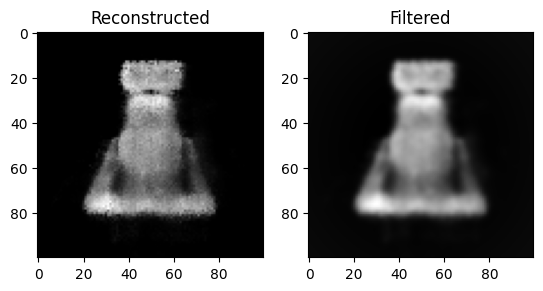

In [62]:
plot_images(reconstructed_gray, bandpassed, gray=True)

# BM3D

In [68]:
from PIL import Image

In [95]:
img_id = 0
psnr_diffs = []
ssim_diffs = []
# lpips_diffs = []

while img_id != len(img_pairs):
    print(img_id)
    reconstructed, ground_truth = img_pairs[img_id]
    y, y_noisy = read_images(ground_truth, reconstructed)
    y = np.array(Image.open(ground_truth)) / 255
    y_noisy = np.array(Image.open(reconstructed)) / 255
    y_est = bm3d_rgb(y_noisy, sigma_psd=30/255)
    
    psnr_diff, ssim_diff = get_metrics_diff(y, y_noisy, y_est, '', use_lpips=False)
    psnr_diffs.append(psnr_diff)
    ssim_diffs.append(ssim_diff)
    # lpips_diffs.append(lpips_diff)
    
    img_id += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [96]:
gaussian_diffs = {
    2: np.mean(psnr_diffs), 3: np.std(psnr_diffs), 
    4: np.mean(ssim_diffs), 5: np.std(ssim_diffs),
    0: np.nan, 1: np.nan}

metrics_diffs['bm3d'] = gaussian_diffs
df.to_csv('metrics_diffs.csv')

In [98]:
df

,metrics,gaussian_blur
0,lpips_mean,-221.424645
1,lpips_std,71.227345
2,psnr_mean,-4.503115
3,psnr_std,2.215057
4,ssim_mean,-2.841470
5,ssim_std,1.029687


In [8]:
metrics_diffs = {
    'Unnamed: 0': {0: 'lpips_mean',
  1: 'lpips_std',
  2: 'psnr_mean',
  3: 'psnr_std',
  4: 'ssim_mean',
  5: 'ssim_std'},
 'gaussian_blur': {0: -221.424645,
  1: 71.22734497156956,
  2: -4.503115,
  3: 2.2150571125311878,
  4: -2.84147,
  5: 1.0296869908375068},
 'median_filter': {2: -5.852715,
  3: 2.911168537507748,
  4: -4.673414999999999,
  5: 1.957168861589362,
  0: -145.469325,
  1: 53.23022460819956},
 'bilateral_filter': {2: -60.22204000000001,
  3: 6.765156944846143,
  4: -31.136725,
  5: 5.275701971242785,
  0: -734.422685,
  1: 242.80210673716525},
 'non_local_means': {2: -3.30201,
  3: 1.625535979269607,
  4: -2.7569600000000003,
  5: 1.6682572398763926,
  0: -120.07709000000001,
  1: 51.74000224460664},
 'wavelete_transform': {2: -5.777282051282051,
  3: 2.3543494822454964,
  4: -2.7629230769230766,
  5: 0.7749797477789053,
  0: -89.7853076923077,
  1: 37.13334377007208},
 'wiener': {2: -3.0283399999999996,
  3: 1.719627024793458,
  4: 5.995335,
  5: 5.778937926018499,
  0: np.nan,
  1: np.nan},
 'anisotropic_diffusion': {2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  0: np.nan,
  1: np.nan},
 'tv_denoise': {2: -0.625185,
  3: 0.8560614818895894,
  4: 5.67722,
  5: 10.706902115999753,
  0: np.nan,
  1: np.nan},
 'notch_filtered': {2: -0.354095,
  3: 0.33303191434906054,
  4: -82.32432,
  5: 13.869100423877535,
  0: np.nan,
  1: np.nan},
 'bandpassed': {2: -95.495365,
  3: 0.9167500541450757,
  4: -94.88599,
  5: 4.029155296076338,
  0: np.nan,
  1: np.nan},
 'bm3d': {2: 0.06764999999999999,
  3: 0.2557107301229262,
  4: -0.6664150000000001,
  5: 0.6022572230990675,
  0: np.nan,
  1: np.nan}}

In [17]:
df = pd.DataFrame(metrics_diffs)
df = df.rename(columns={"Unnamed: 0":"metric"})
df.to_csv("metrics_diff.csv")